In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

In [3]:
nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [4]:
df_range = pd.read_csv('saprc99_range.csv', index_col=0)
df_range.head(10)

,min,max
H2SO4,2.131631e+10,1.223799e+12
HCOOH,1.941420e+10,1.137429e+11
CCO_OH,2.994973e+10,2.073705e+12
RCO_OH,1.275993e+10,1.380322e+12
CCO_OOH,8.695723e+05,1.215977e+12
RCO_OOH,4.160388e+05,7.387218e+11
XN,5.950410e+07,2.010207e+11
XC,4.906034e+12,5.593960e+12
SO2,8.404868e+05,1.202484e+12
O1D,1.000000e-08,7.012137e-01


# Make training data

In [5]:
y0_list = np.random.uniform(np.append(df_range['min'], 0), 
                            np.append(df_range['max'], 1), 
                            size=(5000, 75) )
y0_list.shape

(5000, 75)

In [6]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 4.22 s, sys: 36.8 ms, total: 4.26 s
Wall time: 4.28 s


(5000, 74)

In [7]:
y1_list.max()

10707814247823.502

# Normalize data

In [8]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:74])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [9]:
X_train = np.append(normalizer.transform(y0_list[:,0:74]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(5000, 75)

In [10]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([ 1.00126144,  1.00572036,  1.00005117,  1.00010699,  1.00007776,
        1.00002986,  1.09046724,  1.06732539,  0.98040364,  0.94667542,
        0.99457387,  1.03847139,  0.88787966,  0.93042345,  0.97637025,
        1.42327562,  0.95468279,  9.97149116,  0.4378085 ,  0.978479  ,
        0.95398966,  0.94330875,  0.85758965,  0.72395925,  0.93089007,
        0.89201911,  0.86872867,  5.60275527,  0.98086847,  0.9207103 ,
        0.89551057,  0.87875783,  1.16348932,  0.2771977 ,  0.65284848,
        1.04285422,  0.83632567,  0.76766105,  0.35749595,  0.99729607,
        0.75557021,  0.99952764,  1.01713236,  0.83694057,  0.76614659,
        1.14072691,  0.24537802,  0.70290155,  0.08045323,  0.67042417,
        0.57259091,  0.5388419 ,  0.16212011,  0.85182754,  0.78694937,
        0.77968736,  0.93709055,  0.77796143,  0.76600127,  0.97539438,
        0.87188615,  0.9352429 ,  0.77785376,  0.80656563,  1.50243036,
        0.35076147,  0.5360521 ,  0.55621564,  0.15711216,  1.03

# Fit ANN

In [11]:
x_torch = Variable(torch.from_numpy(X_train).type(torch.FloatTensor))
y_torch = Variable(torch.from_numpy(Y_train).type(torch.FloatTensor))

In [12]:
H1, H2 = 100, 100

model = torch.nn.Sequential(
    torch.nn.Linear(75, H1),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 74)
)

In [13]:
loss_fn = torch.nn.MSELoss()

#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

for t in range(2000):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%200==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

200 0.27286049723625183
400 0.10859920084476471
600 0.06879517436027527
800 0.04921814799308777
1000 0.03795906528830528
1200 0.032103437930345535
1400 0.02761458046734333
1600 0.024479718878865242
1800 0.024723416194319725
2000 0.020989350974559784


In [14]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 11.2 ms, sys: 1.07 ms, total: 12.3 ms
Wall time: 6.94 ms


In [15]:
r2_score(y_pred_numpy, Y_train)

0.92993558633990225

(-20, 20)

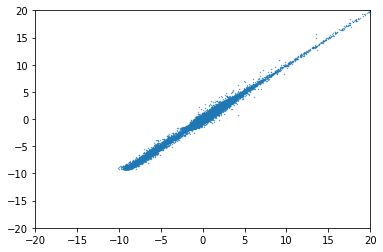

In [16]:
plt.scatter(y_pred_numpy.ravel(), Y_train.ravel(), s=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)

# Test set

In [17]:
y0_test = np.random.uniform(np.append(df_range['min'], 0), 
                            np.append(df_range['max'], 1), 
                            size=(5000, 75) )
y0_list.shape

(5000, 75)

In [18]:
%time y1_test = kpp.onestep(y0_test.T).T

CPU times: user 4.53 s, sys: 96 ms, total: 4.62 s
Wall time: 5.06 s


In [19]:
X_test = np.append(normalizer.transform(y0_test[:,0:74]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [20]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor))
y_test_pred = model(X_torch_test).data.numpy()

CPU times: user 13.1 ms, sys: 3.04 ms, total: 16.1 ms
Wall time: 11.1 ms


In [21]:
r2_score(y_test_pred, Y_test)

0.86422102804418266

(-20, 20)

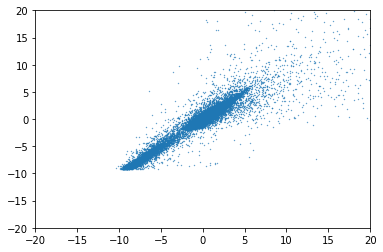

In [22]:
plt.scatter(y_test_pred, Y_test, s=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)

(-20, 20)

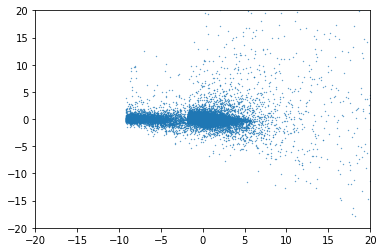

In [23]:
plt.scatter(Y_test, y_test_pred-Y_test, s=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)